In [12]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True


In [3]:
pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]
Note: you may need to restart the kernel to use updated packages.


In [13]:
# Cell 2: Load Batting and Pitching sheets and merge them

batting = pd.read_excel("BaseballTeamData.xlsx", sheet_name="Batting")
pitching = pd.read_excel("BaseballTeamData.xlsx", sheet_name="Pitching")

print("Batting head:")
display(batting.head())

print("Pitching head:")
display(pitching.head())

# Merge on Team + Season
df = pd.merge(
    batting,
    pitching,
    on=["Team", "Season"],
    suffixes=("_bat", "_pit")
)

print("Merged shape:", df.shape)
display(df.head())


Batting head:


,Season,Team,Lg,WAR,XBH,WPA,GP,W,L,WL%,...,SB%,SBatt,Hitting AIR,WPA.1,WPA/LI,Clutch,RE24,REW,RE24/boLI,aLI
0,2025,LAA,AL,8.2,455,-3.4,162,72,90,0.444,...,76.5,115,97,-3.4,-4.9,1.7,-51.11,-5.3,-48.99,1.05
1,2025,ARI,NL,23.5,529,2.8,162,80,82,0.494,...,75.6,160,97,2.8,4.7,-1.9,38.61,3.4,46.13,1.00
2,2025,ATL,NL,23.9,452,-7.7,162,76,86,0.469,...,76.6,107,94,-7.7,-1.9,-5.4,-7.66,-1.0,-9.05,1.05
3,2025,BAL,AL,13.7,461,-5.0,162,75,87,0.463,...,76.6,158,93,-5.0,-4.7,-0.6,-28.97,-3.1,-33.89,0.95
4,2025,BOS,AL,30.2,534,-1.0,162,89,73,0.549,...,78.5,177,96,-1.0,3.0,-4.0,62.32,6.1,48.36,1.05


Pitching head:


,Season,Team,Lg,WAR,BR,PtchR,QS,IR,K%,Pit,...,SV%,GF,GR,K%.1,BB%,K-BB%,Pit.1,Pit/GS,Str,Str%
0,2025,LAA,AL,11.1,2148,-86,49,212,20.5,24123,...,52.8,162,0,20.5,9.9,10.6,24123,NaN,15323,63.52
1,2025,ARI,NL,12.0,2003,-24,68,201,20.8,23841,...,59.2,162,0,20.8,8.1,12.7,23841,NaN,15116,63.40
2,2025,ATL,NL,10.5,1965,-18,69,215,23.2,23972,...,61.8,161,0,23.2,8.7,14.5,23972,NaN,15289,63.78
3,2025,BAL,AL,11.3,2030,-86,54,214,21.9,23846,...,65.5,161,0,21.9,8.5,13.4,23846,NaN,15297,64.15
4,2025,BOS,AL,15.7,1983,55,72,223,22.1,23629,...,61.6,160,0,22.1,8.6,13.5,23629,NaN,15227,64.44


Merged shape: (480, 156)


,Season,Team,Lg_bat,WAR_bat,XBH_bat,WPA_bat,GP_bat,W_bat,L_bat,WL%_bat,...,SV%,GF,GR,K%.1,BB%,K-BB%,Pit.1,Pit/GS,Str,Str%
0,2025,LAA,AL,8.2,455,-3.4,162,72,90,0.444,...,52.8,162,0,20.5,9.9,10.6,24123,NaN,15323,63.52
1,2025,ARI,NL,23.5,529,2.8,162,80,82,0.494,...,59.2,162,0,20.8,8.1,12.7,23841,NaN,15116,63.40
2,2025,ATL,NL,23.9,452,-7.7,162,76,86,0.469,...,61.8,161,0,23.2,8.7,14.5,23972,NaN,15289,63.78
3,2025,BAL,AL,13.7,461,-5.0,162,75,87,0.463,...,65.5,161,0,21.9,8.5,13.4,23846,NaN,15297,64.15
4,2025,BOS,AL,30.2,534,-1.0,162,89,73,0.549,...,61.6,160,0,22.1,8.6,13.5,23629,NaN,15227,64.44


In [14]:
# Cell 3: Create current wins and next-season wins (W_next)

df = df.sort_values(["Team", "Season"]).copy()

# Robust way to pick a wins column from merged data
if "W_bat" in df.columns:
    df["W_current"] = df["W_bat"]
elif "W" in df.columns:
    df["W_current"] = df["W"]
elif "W_pit" in df.columns:
    df["W_current"] = df["W_pit"]
else:
    raise ValueError("Could not find a wins column (W, W_bat, or W_pit). Check your data.")

# Next-season wins within each team
df["W_next"] = df.groupby("Team")["W_current"].shift(-1)
df["Season_next"] = df.groupby("Team")["Season"].shift(-1)

# Drop rows where we don't have the next year
df_model = df.dropna(subset=["W_next"]).copy()
df_model["W_next"] = df_model["W_next"].astype(float)

print("Rows with a following season:", len(df_model))
display(df_model[["Team", "Season", "W_current", "Season_next", "W_next"]].head())


Rows with a following season: 449


,Team,Season,W_current,Season_next,W_next
451,ARI,2010,65,2011.0,94.0
421,ARI,2011,94,2012.0,81.0
391,ARI,2012,81,2013.0,81.0
361,ARI,2013,81,2014.0,64.0
331,ARI,2014,64,2015.0,79.0


In [15]:
# Cell 4: Train/test split and baseline one-predictor model (W_current -> W_next)

# Adjust these if your seasons are different
train_cutoff = 2018   # train on seasons <= this
test_start = 2019      # test on seasons >= this

train_mask = df_model["Season"] <= train_cutoff
test_mask = df_model["Season"] >= test_start

train = df_model[train_mask].copy()
test = df_model[test_mask].copy()

print("Train seasons:", train["Season"].min(), "to", train["Season"].max())
print("Test seasons:", test["Season"].min(), "to", test["Season"].max())
print("Train rows:", len(train), " | Test rows:", len(test))

# Baseline: current wins only
X_train_base = train[["W_current"]]
y_train = train["W_next"]
X_test_base = test[["W_current"]]
y_test = test["W_next"]

baseline_model = LinearRegression()
baseline_model.fit(X_train_base, y_train)

y_pred_base = baseline_model.predict(X_test_base)

mae_base = mean_absolute_error(y_test, y_pred_base)
r2_base = r2_score(y_test, y_pred_base)

print("\n=== Baseline: Linear Regression (current wins -> next-season wins) ===")
print(f"MAE: {mae_base:.2f} wins")
print(f"R^2: {r2_base:.3f}")
print(f"Interpretation: On average, the baseline is off by about {mae_base:.1f} wins.")


Train seasons: 2010 to 2018
Test seasons: 2019 to 2024
Train rows: 269  | Test rows: 180

=== Baseline: Linear Regression (current wins -> next-season wins) ===
MAE: 18.77 wins
R^2: -0.319
Interpretation: On average, the baseline is off by about 18.8 wins.


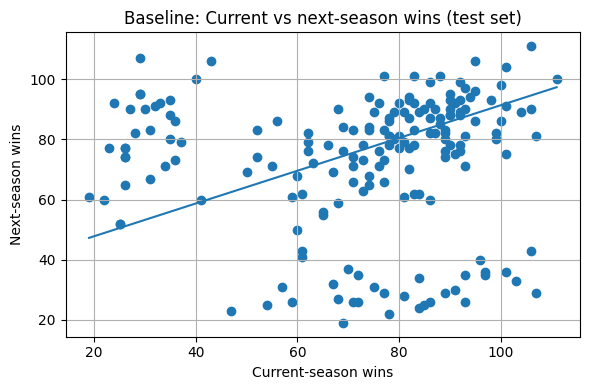

Takeaway: Teams with more wins this year tend to do slightly better next year, but predictions are noisy and the error is large.


In [16]:
# Cell 5: Plot baseline relationship between current and next-season wins

plt.figure()
plt.scatter(X_test_base["W_current"], y_test)

# Build a regression line
w_range = pd.DataFrame({
    "W_current": np.linspace(X_test_base["W_current"].min(),
                             X_test_base["W_current"].max(), 100)
})
w_line = baseline_model.predict(w_range)

plt.plot(w_range["W_current"], w_line)
plt.xlabel("Current-season wins")
plt.ylabel("Next-season wins")
plt.title("Baseline: Current vs next-season wins (test set)")
plt.tight_layout()
plt.show()

print("Takeaway: Teams with more wins this year tend to do slightly better next year, but predictions are noisy and the error is large.")


In [17]:
# Cell 6: Prepare combined batting + pitching features for Random Forest

# Candidate batting features (from the Batting sheet, now with _bat suffix)
batting_candidates = [
    "WAR_bat",    # batting WAR
    "R/Gm_bat",   # runs per game
    "OPS_bat",
    "OPS+_bat",
    "Rbat_bat",
    "Rfield_bat",
    "SB%_bat",
    "AB/SO_bat",
    "LOB_bat"
]

# Candidate pitching features (adjust names if your Pitching sheet uses something different)
pitching_candidates = [
    "ERA_pit",
    "WHIP_pit",
    "FIP_pit",
    "SO9_pit",
    "BB9_pit",
    "HR9_pit",
    "WAR_pit",
    "RA/Gm_pit"   # if you have runs allowed per game or similar
]

# Start with current wins as a predictor too
candidate_features = ["W_current"] + batting_candidates + pitching_candidates

# Keep only features that actually exist in df_model
feature_cols = [col for col in candidate_features if col in df_model.columns]

print("Using these features for the Random Forest:")
for col in feature_cols:
    print(" -", col)

# Drop rows with missing values in any of these features or the target
df_rf = df_model.dropna(subset=feature_cols + ["W_next"]).copy()

train_rf = df_rf[df_rf["Season"] <= train_cutoff].copy()
test_rf = df_rf[df_rf["Season"] >= test_start].copy()

X_train_rf = train_rf[feature_cols]
y_train_rf = train_rf["W_next"]
X_test_rf = test_rf[feature_cols]
y_test_rf = test_rf["W_next"]

print("\nRandom Forest train rows:", len(train_rf), " | test rows:", len(test_rf))


Using these features for the Random Forest:
 - W_current
 - WAR_bat
 - OPS_bat
 - OPS+_bat
 - SB%_bat
 - WAR_pit

Random Forest train rows: 269  | test rows: 180


In [18]:
# Cell 7: Train Random Forest and evaluate performance

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_rf, y_train_rf)
y_pred_rf = rf.predict(X_test_rf)

mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
r2_rf = r2_score(y_test_rf, y_pred_rf)

print("=== Random Forest (Batting + Pitching features) ===")
print(f"MAE: {mae_rf:.2f} wins")
print(f"R^2: {r2_rf:.3f}")
print(f"Interpretation: On average, the RF is off by about {mae_rf:.1f} wins.")

print("\nComparison vs baseline:")
print(f"Baseline MAE: {mae_base:.2f} | RF MAE: {mae_rf:.2f}")
print("Lower MAE is better. If RF MAE is lower than baseline, the extra features help.")


=== Random Forest (Batting + Pitching features) ===
MAE: 17.29 wins
R^2: -0.151
Interpretation: On average, the RF is off by about 17.3 wins.

Comparison vs baseline:
Baseline MAE: 18.77 | RF MAE: 17.29
Lower MAE is better. If RF MAE is lower than baseline, the extra features help.


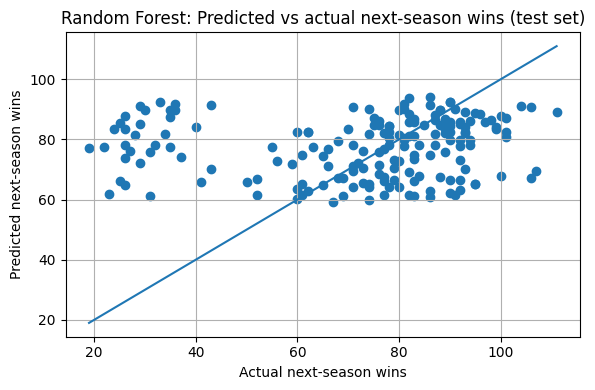

Takeaway: The model tends to shrink predictions toward the middle, and still struggles with very high- and very low-win seasons.


In [19]:
# Cell 8: Predicted vs actual next-season wins for Random Forest

plt.figure()
plt.scatter(y_test_rf, y_pred_rf)

# 45-degree line
min_w = min(y_test_rf.min(), y_pred_rf.min())
max_w = max(y_test_rf.max(), y_pred_rf.max())
plt.plot([min_w, max_w], [min_w, max_w])

plt.xlabel("Actual next-season wins")
plt.ylabel("Predicted next-season wins")
plt.title("Random Forest: Predicted vs actual next-season wins (test set)")
plt.tight_layout()
plt.show()

print("Takeaway: The model tends to shrink predictions toward the middle, and still struggles with very high- and very low-win seasons.")


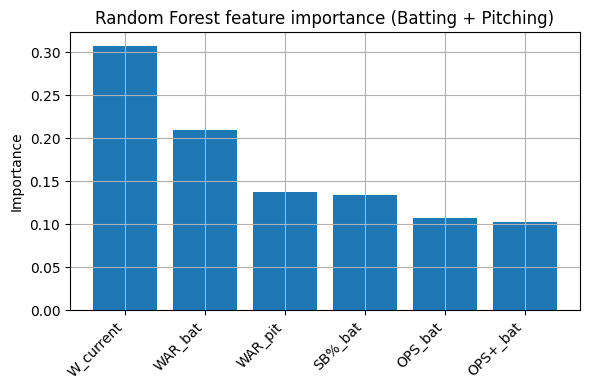

Takeaway: Higher bars show which batting and pitching stats the model relies on most to predict next-season wins.


In [20]:
# Cell 9: Feature importance – which stats matter most?

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

sorted_features = [feature_cols[i] for i in indices]
sorted_importances = importances[indices]

plt.figure()
plt.bar(range(len(sorted_features)), sorted_importances)
plt.xticks(range(len(sorted_features)), sorted_features, rotation=45, ha="right")
plt.ylabel("Importance")
plt.title("Random Forest feature importance (Batting + Pitching)")
plt.tight_layout()
plt.show()

print("Takeaway: Higher bars show which batting and pitching stats the model relies on most to predict next-season wins.")
